# Wild Fire Model Evaluation

This notebooks will evaluate severals model on the wildfire dataset in order to make a predecction on fire intensity and CO2 emissions. A down selection will be made to 2-3 models for further hyper-paramater tuning. 

In [2]:
#optional code if warnings become over bearing 
import warnings
warnings.filterwarnings('ignore')

In [3]:
#optional code to ensure everyone is on the right version
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.3.


# Import all the models we will likely use for classificaiton

In [2]:
%matplotlib inline

import os
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

import os
import pickle


# Helper function to save estimator
Saves to current working directory

In [5]:
def save_estimator (estimator) :
          
    outpath = estimator.__class__.__name__.lower().replace(" ", "-") + ".pickle"
    with open(outpath, 'wb') as f:
        pickle.dump(estimator, f)
        f.close()
        
    #print("\nFitted model written to:\n{}".format(os.path.abspath(outpath)))

In [6]:
def open_estimator(filename) :
    
    infile = open(filename,'rb')
    estimator = pickle.load(infile)
    infile.close()

    print ("Unpickled file", filename)
    
    return estimator

# Read the Fire Data From Disk to Save Time.
During the feature evaluation the data was pulled from the database and stored locally

In [3]:
#Read the data from disk for faster access

#get a sample of the data set to n rows, leave blank for all
df_fires = pd.read_csv('data/FireIntensity_Model_June7_Clean.csv').sample(20000)




# Show the shape of the file. 
Check data to ensure it's correct.


In [4]:
#show the shape of the data

print (df_fires.shape)
print(df_fires.head(3))
print (df_fires.describe())
print(df_fires.columns)

(20000, 22)
        latitude  longitude  doy  month  year cluster_reference  fire_region  \
988811   45.3273  -114.4820  227      8  2012          2012_589            1   
435210   33.5413  -109.3494  185      7  2007          2007_147            4   
9171     48.3024  -119.6842   78      3  2003         2003_6226            1   

        season  covertype  fuelcode  ...  temperature  humidity  \
988811       1          3      1200  ...        76.40      0.17   
435210       1          3      1220  ...        87.43      0.19   
9171         3          3      1200  ...        37.66      0.67   

        precip_intensity  visibility  wind_speed  wind_gust  brightness  \
988811               0.0    9.216293        5.49      10.67       333.2   
435210               0.0    9.216293        4.47      14.22       335.6   
9171                 0.0    9.997000        2.71       8.43       309.9   

        fire_intensity  bright_t31    frp  
988811          Severe       296.7   52.2  
435210   

# Store the key features.
Eliminated the variables related directly to fire_intensity due to overfit. 
Consider eliminating doy

In [7]:
features = ['fire_region', 'season', 'fuelcode', 'prefire_fuel', 
            'fuel_moisture_class', 'temperature', 'humidity', 
             'wind_speed']

target = ['fire_intensity']


y = df_fires[target]
X = df_fires[features]


In [8]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

    
y = LabelEncoder().fit_transform(y)

numeric_features = ['temperature', 'humidity', 'wind_speed']

numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

#categorical_features = ['fire_region', 'season', 'fuelcode', 'fuel_moisture_class']
categorical_features = ['fuelcode']    

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

"""
column_trans = make_column_transformer((OneHotEncoder(), ['fire_region', 'season',
                                'fuelcode', 'fuel_moisture_class']),
                                 remainder='passthrough')
    
column_trans.fit_transform(X)
y = LabelEncoder().fit_transform(y)
"""

"\ncolumn_trans = make_column_transformer((OneHotEncoder(), ['fire_region', 'season',\n                                'fuelcode', 'fuel_moisture_class']),\n                                 remainder='passthrough')\n    \ncolumn_trans.fit_transform(X)\ny = LabelEncoder().fit_transform(y)\n"

# Define the models to test
<b>Commented out slower performing models and limited the interations/estimators for speed</b>

In [11]:
'''
    models = [
        SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
        SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
        LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
        BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
        RandomForestClassifier(n_estimators=100),
        ]
        
'''


models = [
        #SVC(gamma='auto'), 
        #NuSVC(gamma='auto'),
        #LinearSVC(),
        #SGDClassifier(max_iter=25, tol=1e-3),  
        #LogisticRegression(solver='lbfgs'),
        #BaggingClassifier(), 
        #ExtraTreesClassifier(n_estimators=5), 
        RandomForestClassifier(n_estimators=5),
        ]



# Function to Fit and predict the scores of the model. 
Helps in the initial down selection

In [13]:
from datetime import datetime

def score_model(X, y, estimator, **kwargs):
    
    """
    Test various estimators.
   
   
    #y = LabelEncoder().fit_transform(y)

   
    
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories = 'auto')), 
         ('estimator', estimator)
    ])
    """ 
    
    model = Pipeline([
         ('preprocessor', preprocessor), 
         ('estimator', estimator)
    ])
   



    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("start Time =", current_time)
  
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected = y
    predicted = model.predict(X)
    
   
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='macro')))
   
    now = datetime.now()

    current_time = now.strftime("%H:%M:%S")
    print("End Time =", current_time)
    
    #save_estimator(estimator)
    
    
    
    


# Iterate through the different models

In [14]:
for model in models:
    score_model(X, y, model)

start Time = 03:01:50
RandomForestClassifier: 0.8834718883515353
End Time = 03:01:52


# Function to visualize the model out using yellow brick classification report.
<b> Error is thrown here using the LabelEncoder and one_hot_encoder <b/>

In [15]:
def visualize_model(X, y, estimator):
    
    """
    Test various estimators.
    
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder(categories='auto')), 
         ('estimator', estimator)
    ])
    """ 
    
    
    model = Pipeline([
         ('preprocessor', preprocessor), 
         ('estimator', estimator)
    ])
   
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['Low', 'Medium', 'High', 'Severe'], 
        cmap="Reds", 
        support=True,
        size=(800, 660)
    )
    
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    
    visualizer.fit(X_train, y_train)  
    
    
    visualizer.score(X_test, y_test)
    
    #optional
    #visualizer.show(outpath=estimator.__class__.__name__ + ".png")  
    
    visualizer.show()
 

    

# Iterate through the models to visualize

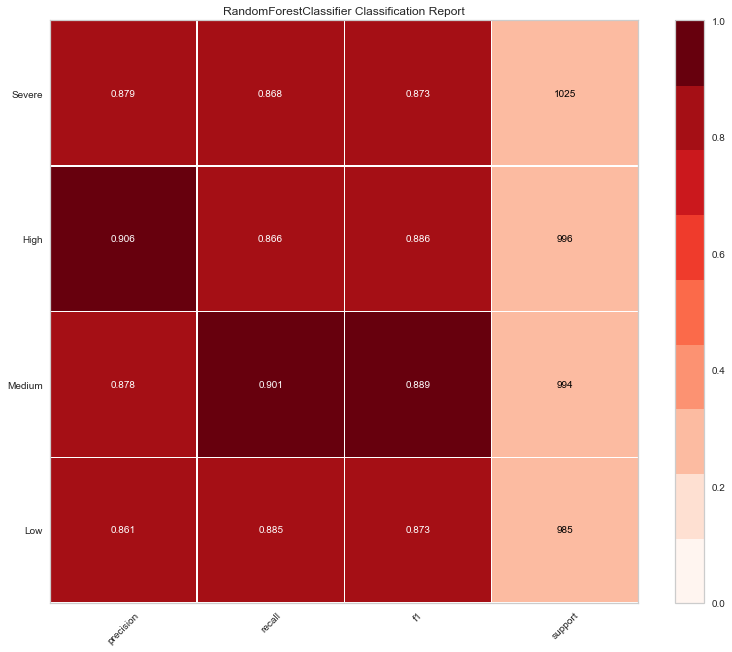

In [16]:
for model in models:
    visualize_model(X, y, model)
    